In [ ]:
# this code is copyed by following url
# https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/centernet_on_device.ipynb

In [ ]:
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from object_detection.utils import label_map_util
import cv2
import copy
import numpy as np
from object_detection.utils import visualization_utils as viz_utils

In [4]:
def detect(interpreter, input_tensor, include_keypoint=False):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    include_keypoint: True if model supports keypoints output. See
      https://cocodataset.org/#keypoints-2020

  Returns:
    A sequence containing the following output tensors:
      boxes: a numpy array of shape [N, 4]
      classes: a numpy array of shape [N]. Note that class indices are 
        1-based, and match the keys in the label map.
      scores: a numpy array of shape [N] or None.  If scores=None, then
        this function assumes that the boxes to be plotted are groundtruth
        boxes and plot all boxes as black with no classes or scores.
      category_index: a dict containing category dictionaries (each holding
        category index `id` and category name `name`) keyed by category 
        indices.
    If include_keypoints is True, the following are also returned:
      keypoints: (optional) a numpy array of shape [N, 17, 2] representing
        the yx-coordinates of the detection 17 COCO human keypoints
        (https://cocodataset.org/#keypoints-2020) in normalized image frame
        (i.e. [0.0, 1.0]). 
      keypoint_scores: (optional) a numpy array of shape [N, 17] representing the
        keypoint prediction confidence scores.
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  interpreter.set_tensor(input_details[0]['index'], input_tensor.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  num_detections = interpreter.get_tensor(output_details[3]['index'])

  if include_keypoint:
    kpts = interpreter.get_tensor(output_details[4]['index'])
    kpts_scores = interpreter.get_tensor(output_details[5]['index'])
    return boxes, classes, scores, num_detections, kpts, kpts_scores
  else:
    return boxes, classes, scores, num_detections

# Utility for visualizing results
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    keypoints=None,
                    keypoint_scores=None,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    keypoints: (optional) a numpy array of shape [N, 17, 2] representing the 
      yx-coordinates of the detection 17 COCO human keypoints
      (https://cocodataset.org/#keypoints-2020) in normalized image frame
      (i.e. [0.0, 1.0]). 
    keypoint_scores: (optional) anumpy array of shape [N, 17] representing the
      keypoint prediction confidence scores.
    figsize: size for the figure.
    image_name: a name for the image file.
  """

  keypoint_edges = [(0, 1),
        (0, 2),
        (1, 3),
        (2, 4),
        (0, 5),
        (0, 6),
        (5, 7),
        (7, 9),
        (6, 8),
        (8, 10),
        (5, 6),
        (5, 11),
        (6, 12),
        (11, 12),
        (11, 13),
        (13, 15),
        (12, 14),
        (14, 16)]
  image_np_with_annotations = image_np.copy()
  # Only visualize objects that get a score > 0.3.
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=keypoint_edges,
      use_normalized_coordinates=True,
      min_score_thresh=0.3)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    return image_np_with_annotations

In [5]:
%matplotlib inline
model_path = "/tf/work/models/centernet_hg104_512x512_coco17_tpu-8/exported_model/tflite/model.tflite"
label_map_path = "/tf/work/data/tf_label_map.pbtxt"
image_path = "/tf/work/data/test_images/IMG_6545.jpg"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Label map can be used to figure out what class ID maps to what
# label. `label_map.txt` is human-readable.

category_index = label_map_util.create_category_index_from_labelmap(label_map_path)
label_id_offset = 1

image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
image_numpy = image.numpy()

input_tensor = tf.convert_to_tensor(image_numpy, dtype=tf.float32)
# Note that CenterNet doesn't require any pre-processing except resizing to the
# input size that the TensorFlow Lite Interpreter was generated with.
input_tensor = tf.image.resize(input_tensor, (512,512))
boxes, classes, scores, num_detections = detect(interpreter, input_tensor)

vis_image = plot_detections(
                image_numpy[0],
                boxes[0],
                classes[0].astype(np.int32) + label_id_offset,
                scores[0],
                category_index)
plt.figure(figsize=(30,20))
plt.imshow(vis_image)

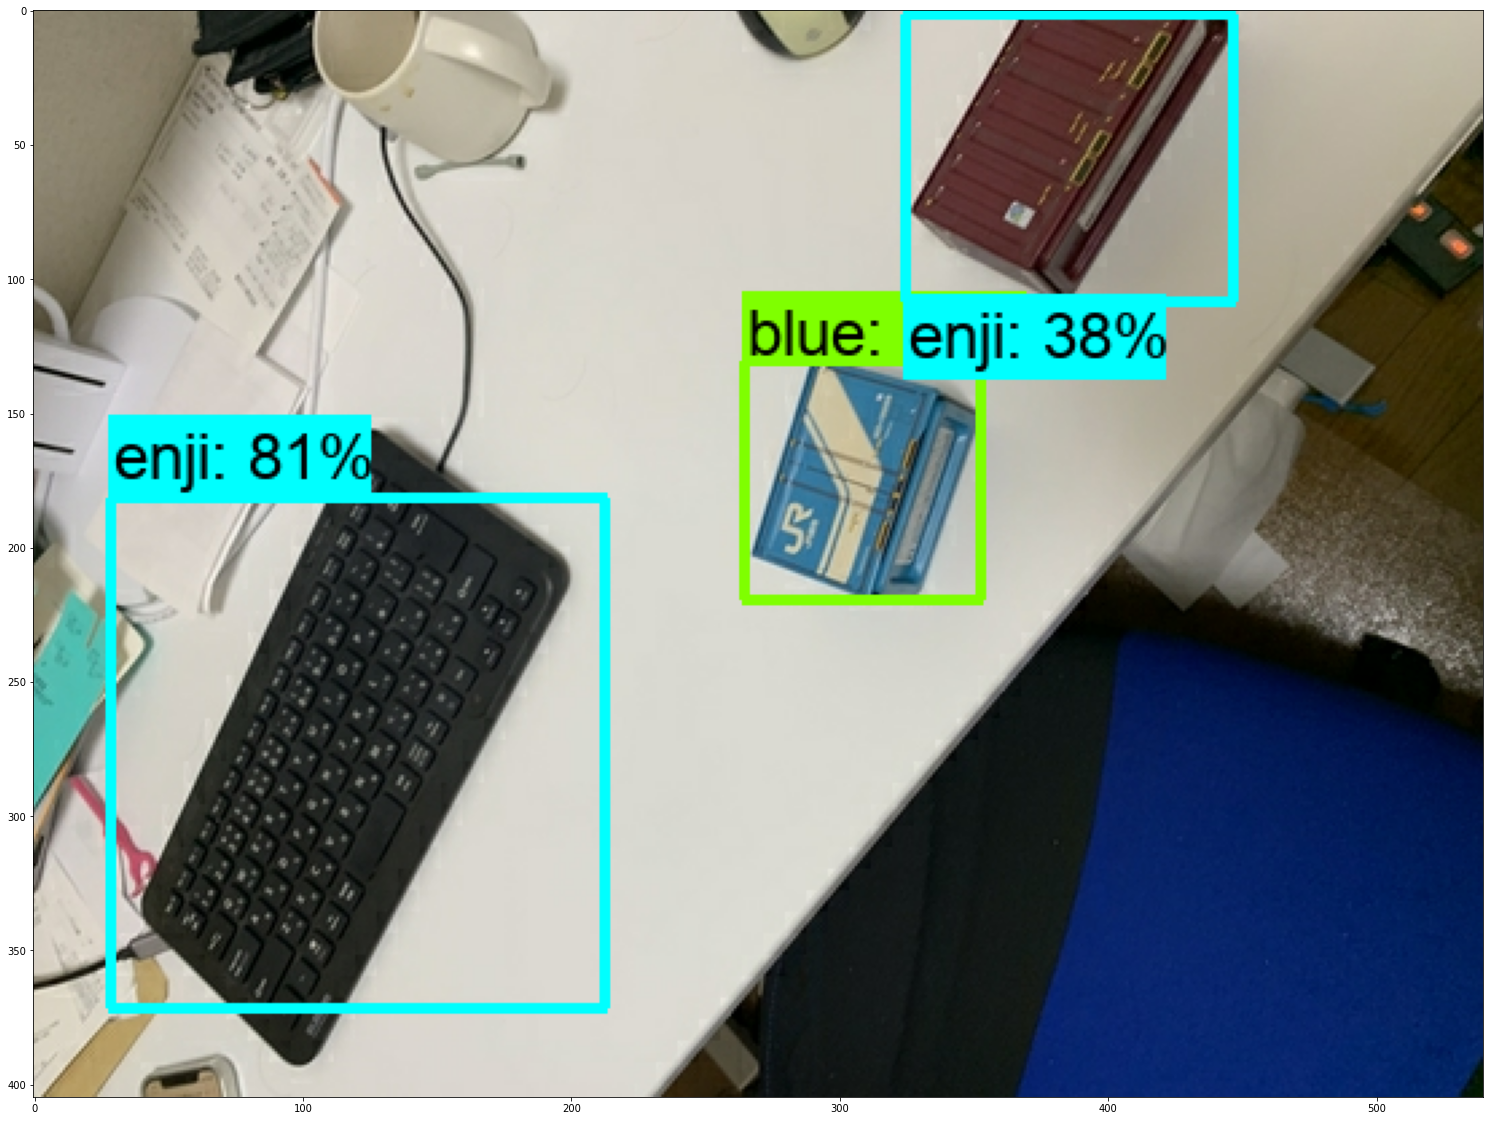

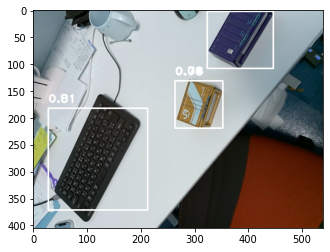

In [29]:
image_path = "/tf/work/data/test_images/IMG_6545.jpg"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
image_width, image_height = image.shape[1], image.shape[0]
debug_image = copy.deepcopy(image)
SCORE_THRESHOLD = 0.05

for i in range(int(num_detections[0])):
    score = scores[0][i]
    bbox = boxes[0][i]
    #class_id = output["detection_classes"][i].astype(np.int)
    
    if score < SCORE_THRESHOLD:
        continue

    x1, y1 = int(bbox[1] * image_width), int(bbox[0] * image_height)
    x2, y2 = int(bbox[3] * image_width), int(bbox[2] * image_height)

    # 推論結果描画(Inference result drawing)
    cv2.rectangle(debug_image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    cv2.putText(debug_image, str('{:.2f}'.format(score)), (x1, y1-10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.rectangle(debug_image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
plt.imshow(debug_image)
plt.show()

In [30]:
cv2.imwrite("centernet_result.jpg", debug_image)

True